In [1]:
import torch
import numpy as np
import pykaruiflow as kf
import os
import os 
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Defining a neural network class

In [2]:
class Linear(kf.nn.Module):
    def __init__(self, dim1, dim2):
        super().__init__()
        value = np.random.randn(dim1, dim2).astype('float32') / np.sqrt(dim1 / 2)
        self.weights = kf.core.Parameter(value)
        
    def forward(self, x):
        return kf.matmul(x, self.weights)
    

class LinearReLU(kf.nn.Module):
    def __init__(self, dim1, dim2):
        super().__init__()
        self.linear = Linear(dim1, dim2)
        
    def forward(self, x):
        x = self.linear(x)
        return kf.relu(x)
    
class NN(kf.nn.Module):
    def __init__(self, in_dim, dim=128, n_classes=10):
        super().__init__()
        self.layer1 = LinearReLU(in_dim, dim)
        self.layer2 = LinearReLU(dim, dim)
        self.layer3 = Linear(dim, n_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)        
        x = self.layer3(x)
        return kf.softmax(x, dim=-1)

In [3]:
nn = NN(28 * 28)

## Training

In [4]:
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader

# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Hyper parameters
BATCH_SIZE = 128
EPOCHS = 3
optim = kf.optim.SGD(nn.parameters(), lr=1e-3, momentum=0.99)

In [6]:
indices = np.arange(BATCH_SIZE)

# Cross-entropy
def loss_fn(x, y, nn, n_classes=10):
    x = kf.tensor(x)
    y_pred = nn(x)
    log_pred = kf.log(y_pred)
    one_hot = np.zeros((BATCH_SIZE, n_classes), dtype='float32')
    one_hot[indices, y] = 1.
    one_hot = kf.tensor(one_hot)
    return kf.sum(log_pred * one_hot, dim=[0, 1]) * -1. 

In [7]:
def preprocess(im):
    im = np.asarray(im, dtype='float32').reshape(-1) / 127 - 1
    return im

In [8]:
# Dataset
mnist_train = MNIST(root='.', train=True, download=True, transform=lambda x: preprocess(x))
mnist_train = DataLoader(mnist_train, batch_size=BATCH_SIZE)

In [9]:
for epoch in range(EPOCHS):
    for i, (im, label) in enumerate(mnist_train):
        if len(label) != BATCH_SIZE:
            break
            
        loss = loss_fn(im.numpy(), label.numpy(), nn)
        loss.backward()
        optim.step()
        optim.zero_grad()

        if i % 50 == 0:
            print('Epoch:', epoch, 'Iteration:', i, 'Loss:', loss.numpy())

Epoch: 0 Iteration: 0 Loss: 369.45782
Epoch: 0 Iteration: 50 Loss: 117.93898
Epoch: 0 Iteration: 100 Loss: 64.69398
Epoch: 0 Iteration: 150 Loss: 79.151596
Epoch: 0 Iteration: 200 Loss: 37.67496
Epoch: 0 Iteration: 250 Loss: 52.516354
Epoch: 0 Iteration: 300 Loss: 34.244675
Epoch: 0 Iteration: 350 Loss: 59.268475
Epoch: 0 Iteration: 400 Loss: 40.718704
Epoch: 0 Iteration: 450 Loss: 41.304325
Epoch: 1 Iteration: 0 Loss: 20.119576
Epoch: 1 Iteration: 50 Loss: 21.621922
Epoch: 1 Iteration: 100 Loss: 19.694801
Epoch: 1 Iteration: 150 Loss: 24.203106
Epoch: 1 Iteration: 200 Loss: 26.21271
Epoch: 1 Iteration: 250 Loss: 27.684517
Epoch: 1 Iteration: 300 Loss: 20.936888
Epoch: 1 Iteration: 350 Loss: 38.271362
Epoch: 1 Iteration: 400 Loss: 30.414124
Epoch: 1 Iteration: 450 Loss: 26.91835
Epoch: 2 Iteration: 0 Loss: 11.3697405
Epoch: 2 Iteration: 50 Loss: 16.813648
Epoch: 2 Iteration: 100 Loss: 13.512104
Epoch: 2 Iteration: 150 Loss: 19.908379
Epoch: 2 Iteration: 200 Loss: 15.218263
Epoch: 2 Ite

## Testing

In [10]:
import matplotlib.pyplot as plt

In [11]:
mnist_test = MNIST(root='.', train=False, download=True, transform=lambda x: preprocess(x))

In [12]:
mnist_test = DataLoader(mnist_test, batch_size=BATCH_SIZE)

In [13]:
im, label = next(iter(mnist_test))
im, label = im.numpy(), label.numpy()

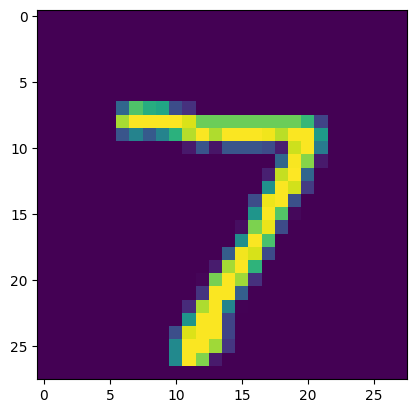

In [14]:
plt.imshow(im[0].reshape(28, 28))

In [16]:
nn(kf.tensor(im[0][None, ...])).numpy().argmax(axis=-1)

array([7])

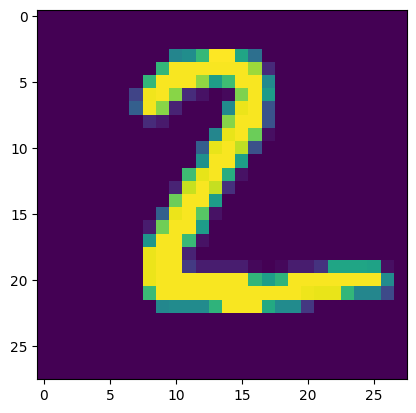

In [17]:
plt.imshow(im[1].reshape(28, 28))

In [18]:
nn(kf.tensor(im[1][None, ...])).numpy().argmax(axis=-1)

array([2])

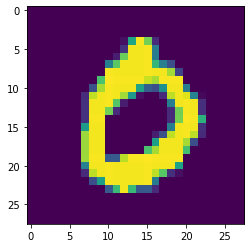

In [65]:
plt.imshow(im[3].reshape(28, 28))

In [60]:
nn.to('cpu')

In [66]:
nn(im[3][None, ...]).numpy().argmax(axis=-1)

array([0], dtype=int64)